In [75]:
import logging
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
from utils.data_loader import DataLoader
from darts import TimeSeries
from darts.metrics import mae, rmse

In [22]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [34]:
with open(Path("../config/base_config.yaml"), "r") as f:
    config = yaml.safe_load(f)

# Initialize DataLoader
data_loader = DataLoader(config)


In [55]:
dataset = "BPI2017"
model_name = 'theta'
model_group = "statistical"
horizon = 7
data_path = Path("../data/processed/time_series_df.h5")

In [37]:
data = pd.read_hdf(data_path, key=dataset)
data = TimeSeries.from_dataframe(data)

2025-03-12 13:29:41,797 - darts.timeseries - WARNING - The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


In [38]:
train, val, test = data_loader.split_data(data, model_group)

In [39]:
train_t, val_t, test_t, transformer = data_loader.transform_data(train, val, test, model_group)

In [40]:
input_seq, output_seq = data_loader.create_expanding_io_data(
            train=train_t,
            val=val_t,
            test=test_t,
            horizon=horizon
        )

In [44]:
len(input_seq)

58

In [46]:
len(output_seq)

58

In [51]:
output_seq[0]

<TimeSeries (DataArray) (time: 7, component: 21, sample: 1)> Size: 1kB
array([[[4.20469362e+00],
        [4.20469362e+00],
        [4.15888408e+00],
        [3.21887682e+00],
        [4.11087486e+00],
        [3.73767062e+00],
        [6.93148181e-01],
        [1.94591115e+00],
        [1.09861329e+00],
        [6.93148181e-01],
        [1.00000000e-06],
        [1.00000000e-06],
        [1.00000000e-06],
        [1.00000000e-06],
        [1.00000000e-06],
        [6.93148181e-01],
        [1.00000000e-06],
        [1.00000000e-06],
        [1.00000000e-06],
        [1.00000000e-06],
...
        [4.96981430e+00],
        [4.84418809e+00],
        [3.89182130e+00],
        [4.52178958e+00],
        [4.30406609e+00],
        [4.54329578e+00],
        [4.21950871e+00],
        [2.56495036e+00],
        [1.79176047e+00],
        [1.60943891e+00],
        [2.77258972e+00],
        [2.39789627e+00],
        [1.79176047e+00],
        [2.07944254e+00],
        [6.93148181e-01],
        [1.00000000e-06],
        [1.00000000e-06],
        [1.00000000e-06],
        [1.00000000e-06],
        [1.00000000e-06]]])
Coordinates:
  * time       (time) datetime64[ns] 56B 2016-10-22 2016-10-23 ... 2016-10-28
  * component  (component) object 168B '▶ -> O_Create Offer' ... 'O_Sent (onl...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [53]:
actuals_seq = [
    data_loader.inverse_transform(act, transformer, model_group)
    for act in output_seq
]

In [57]:
actuals_all = pd.concat([act.pd_dataframe() for act in actuals_seq])

In [69]:
actuals_all.shape

(406, 21)

In [72]:
actuals_all.head()

component,▶ -> O_Create Offer,O_Create Offer -> O_Created,O_Created -> O_Sent (mail and online),O_Sent (mail and online) -> O_Cancelled,O_Cancelled -> ■,O_Sent (mail and online) -> O_Returned,O_Returned -> O_Accepted,O_Accepted -> ■,O_Created -> O_Cancelled,O_Created -> O_Sent (online only),...,O_Returned -> O_Refused,O_Refused -> ■,O_Sent (mail and online) -> O_Refused,O_Returned -> O_Cancelled,O_Sent (online only) -> O_Cancelled,O_Returned -> ■,O_Sent (online only) -> O_Refused,O_Created -> O_Refused,O_Sent (mail and online) -> ■,O_Sent (online only) -> ■
time,,,,,,,,,,,,,,,,,,,,,
2016-10-22,66.0,66.0,63.0,24.0,60.0,41.0,1.0,6.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-10-23,0.0,0.0,0.0,0.0,56.0,0.0,0.0,9.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-24,179.0,179.0,159.0,60.0,230.0,93.0,59.0,472.0,8.0,12.0,...,12.0,18.0,4.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0
2016-10-25,258.0,258.0,247.0,103.0,73.0,137.0,60.0,60.0,4.0,7.0,...,18.0,14.0,5.0,10.0,2.0,0.0,1.0,0.0,0.0,0.0
2016-10-26,176.0,176.0,162.0,68.0,33.0,93.0,113.0,60.0,5.0,9.0,...,25.0,26.0,3.0,10.0,3.0,0.0,0.0,0.0,0.0,0.0


In [59]:
predictions_all = pd.read_parquet(f"../results/{dataset}/horizon_{horizon}/predictions/{model_group}/{model_name}_all_predictions.parquet")

In [70]:
predictions_all.shape

(406, 21)

In [73]:
predictions_all.head()

▶ -> O_Create Offer  \
sequence_start_time horizon_step                        
2016-10-22          0                      151.276853   
                    1                        0.383119   
                    2                      443.042022   
                    3                      422.428276   
                    4                      349.062374   

                                  O_Create Offer -> O_Created  \
sequence_start_time horizon_step                                
2016-10-22          0                              151.276853   
                    1                                0.383119   
                    2                              443.042022   
                    3                              422.428276   
                    4                              349.062374   

                                  O_Created -> O_Sent (mail and online)  \
sequence_start_time horizon_step                                          
2016-10-22          0                                        127.512813   
                    1                                          0.325314   
                    2                                        361.563926   
                    3                                        344.520281   
                    4                                        284.220575   

                                  O_Sent (mail and online) -> O_Cancelled  \
sequence_start_time horizon_step                                            
2016-10-22          0                                           39.147659   
                    1                                            0.234621   
                    2                                          106.107043   
                    3                                           99.570693   
                    4                                           86.952755   

                                  O_Cancelled -> ■  \
sequence_start_time horizon_step                     
2016-10-22          0                    59.866727   
                    1                    61.678214   
                    2                    57.624138   
                    3                    60.019754   
                    4                    61.836890   

                                  O_Sent (mail and online) -> O_Returned  \
sequence_start_time horizon_step                                           
2016-10-22          0                                          77.617801   
                    1                                           0.287023   
                    2                                         242.387668   
                    3                                         235.446566   
                    4                                         185.291223   

                                  O_Returned -> O_Accepted  O_Accepted -> ■  \
sequence_start_time horizon_step                                              
2016-10-22          0                             2.825562         2.744940   
                    1                             0.025056         0.541462   
                    2                           242.867500       323.029151   
                    3                           331.776987       416.386487   
                    4                           543.410568       434.149733   

                                  O_Created -> O_Cancelled  \
sequence_start_time horizon_step                             
2016-10-22          0                             2.700903   
                    1                             0.084197   
                    2                             7.869922   
                    3                             6.863319   
                    4                             5.588053   

                                  O_Created -> O_Sent (online only)  ...  \
sequence_start_time horizon_step                                     ...   
2016-10-22          0                                      

In [74]:
actuals_values = actuals_all.values
predictions_values = predictions_all.values

In [83]:
predictions_all.max()

▶ -> O_Create Offer                        443.042022
O_Create Offer -> O_Created                443.042022
O_Created -> O_Sent (mail and online)      361.563926
O_Sent (mail and online) -> O_Cancelled    106.107043
O_Cancelled -> ■                            66.798011
O_Sent (mail and online) -> O_Returned     242.387668
O_Returned -> O_Accepted                   543.410568
O_Accepted -> ■                            948.324407
O_Created -> O_Cancelled                     7.999866
O_Created -> O_Sent (online only)           14.078211
O_Sent (online only) -> O_Returned           9.041745
O_Returned -> O_Refused                     18.443840
O_Refused -> ■                             116.769471
O_Sent (mail and online) -> O_Refused        3.886628
O_Returned -> O_Cancelled                   19.140584
O_Sent (online only) -> O_Cancelled          4.379873
O_Returned -> ■                                   inf
O_Sent (online only) -> O_Refused                 inf
O_Created -> O_Refused      

In [84]:
rounded_predictions = np.round(predictions_values, 2)

In [85]:
mae_value = np.abs(rounded_predictions - actuals_values).mean()
rmse_value = np.sqrt(((rounded_predictions - actuals_values) ** 2).mean())

/var/folders/mt/5h6lnpgn3j91r3p_y4f2n8hm0000gn/T/ipykernel_4758/962821998.py:2: RuntimeWarning: overflow encountered in square
  rmse_value = np.sqrt(((rounded_predictions - actuals_values) ** 2).mean())


In [88]:
diff = rounded_predictions - actuals_values
abs_diff = np.abs(diff)
print(abs_diff)

[[8.5280e+01 8.5280e+01 6.4510e+01 ... 2.2000e-01 0.0000e+00 0.0000e+00]
 [3.8000e-01 3.8000e-01 3.3000e-01 ... 1.6000e-01 0.0000e+00 0.0000e+00]
 [2.6404e+02 2.6404e+02 2.0256e+02 ... 1.7000e-01 0.0000e+00 0.0000e+00]
 ...
 [8.7270e+01 8.7270e+01 6.9130e+01 ... 9.0000e-01 4.1000e-01 1.0000e-02]
 [7.1140e+01 7.1140e+01 5.3470e+01 ... 8.0000e-02 6.1000e-01 1.0000e-02]
 [7.2430e+01 7.2430e+01 6.1730e+01 ... 1.1000e-01 5.6000e-01 1.0000e-02]]


In [94]:
abs_diff

array([[8.5280e+01, 8.5280e+01, 6.4510e+01, ..., 2.2000e-01, 0.0000e+00,
        0.0000e+00],
       [3.8000e-01, 3.8000e-01, 3.3000e-01, ..., 1.6000e-01, 0.0000e+00,
        0.0000e+00],
       [2.6404e+02, 2.6404e+02, 2.0256e+02, ..., 1.7000e-01, 0.0000e+00,
        0.0000e+00],
       ...,
       [8.7270e+01, 8.7270e+01, 6.9130e+01, ..., 9.0000e-01, 4.1000e-01,
        1.0000e-02],
       [7.1140e+01, 7.1140e+01, 5.3470e+01, ..., 8.0000e-02, 6.1000e-01,
        1.0000e-02],
       [7.2430e+01, 7.2430e+01, 6.1730e+01, ..., 1.1000e-01, 5.6000e-01,
        1.0000e-02]])

In [102]:
predictions_all.max()

▶ -> O_Create Offer                        443.042022
O_Create Offer -> O_Created                443.042022
O_Created -> O_Sent (mail and online)      361.563926
O_Sent (mail and online) -> O_Cancelled    106.107043
O_Cancelled -> ■                            66.798011
O_Sent (mail and online) -> O_Returned     242.387668
O_Returned -> O_Accepted                   543.410568
O_Accepted -> ■                            948.324407
O_Created -> O_Cancelled                     7.999866
O_Created -> O_Sent (online only)           14.078211
O_Sent (online only) -> O_Returned           9.041745
O_Returned -> O_Refused                     18.443840
O_Refused -> ■                             116.769471
O_Sent (mail and online) -> O_Refused        3.886628
O_Returned -> O_Cancelled                   19.140584
O_Sent (online only) -> O_Cancelled          4.379873
O_Returned -> ■                                   inf
O_Sent (online only) -> O_Refused                 inf
O_Created -> O_Refused      

In [103]:
actuals_all.max()

component
▶ -> O_Create Offer                        258.0
O_Create Offer -> O_Created                258.0
O_Created -> O_Sent (mail and online)      247.0
O_Sent (mail and online) -> O_Cancelled    103.0
O_Cancelled -> ■                           230.0
O_Sent (mail and online) -> O_Returned     137.0
O_Returned -> O_Accepted                   113.0
O_Accepted -> ■                            472.0
O_Created -> O_Cancelled                    12.0
O_Created -> O_Sent (online only)           17.0
O_Sent (online only) -> O_Returned          13.0
O_Returned -> O_Refused                     26.0
O_Refused -> ■                              32.0
O_Sent (mail and online) -> O_Refused       12.0
O_Returned -> O_Cancelled                   17.0
O_Sent (online only) -> O_Cancelled          8.0
O_Returned -> ■                              2.0
O_Sent (online only) -> O_Refused            2.0
O_Created -> O_Refused                       1.0
O_Sent (mail and online) -> ■                2.0
O_Sent (on

In [104]:
max_val = predictions_all.max().max()
max_col = predictions_all.max().idxmax()
max_row = predictions_all[max_col].idxmax()
print(f"Maximum value: {max_val}, at position: [{max_row}, {max_col}]")


Maximum value: inf, at position: [(Timestamp('2016-12-07 00:00:00'), 5), O_Returned -> ■]


In [106]:
predictions_all

▶ -> O_Create Offer  \
sequence_start_time horizon_step                        
2016-10-22          0                      151.276853   
                    1                        0.383119   
                    2                      443.042022   
                    3                      422.428276   
                    4                      349.062374   
...                                               ...   
2016-12-18          2                      215.344973   
                    3                      183.842156   
                    4                      176.266904   
                    5                      157.139669   
                    6                       90.425307   

                                  O_Create Offer -> O_Created  \
sequence_start_time horizon_step                                
2016-10-22          0                              151.276853   
                    1                                0.383119   
                    2                              443.042022   
                    3                              422.428276   
                    4                              349.062374   
...                                                       ...   
2016-12-18          2                              215.344973   
                    3                              183.842156   
                    4                              176.266904   
                    5                              157.139669   
                    6                               90.425307   

                                  O_Created -> O_Sent (mail and online)  \
sequence_start_time horizon_step                                          
2016-10-22          0                                        127.512813   
                    1                                          0.325314   
                    2                                        361.563926   
                    3                                        344.520281   
                    4                                        284.220575   
...                                                                 ...   
2016-12-18          2                                        179.650736   
                    3                                        152.978695   
                    4                                        147.127673   
                    5                                        129.471995   
                    6                                         77.729192   

                                  O_Sent (mail and online) -> O_Cancelled  \
sequence_start_time horizon_step                                            
2016-10-22          0                                           39.147659   
                    1                                            0.234621   
                    2                                          106.107043   
                    3                                           99.570693   
                    4                                           86.952755   
...                                                                   ...   
2016-12-18          2                                           50.243563   
                    3                                           45.312662   
                    4                                           40.533119   
                    5                                           38.127269   
                    6                                           22.126907   

                                  O_Cancelled -> ■  \
sequence_start_time horizon_step                     
2016-10-22          0                    59.866727   
                    1                    61.678214   
                    2                    57.624138   
                    3                    60.019754   
                    4                    61.836890   
...                                            ...   
2016-12-18          2               

In [105]:
threshold = 1e10  # Adjust based on your data
large_values = predictions_all > threshold
if large_values.values.any():
    # Get positions of large values
    large_positions = np.where(large_values.values)
    for i, j in zip(*large_positions):
        row_idx = predictions_all.index[i]
        col_name = predictions_all.columns[j]
        value = predictions_all.iloc[i, j]
        print(f"Large value: {value} at position [{row_idx}, {col_name}]")


Large value: 3.6699490538637897e+213 at position [(Timestamp('2016-10-26 00:00:00'), 2), O_Sent (online only) -> O_Refused]
Large value: 1.883317904863013e+211 at position [(Timestamp('2016-10-26 00:00:00'), 5), O_Sent (online only) -> O_Refused]
Large value: 4.751684910992138e+183 at position [(Timestamp('2016-11-01 00:00:00'), 2), O_Sent (online only) -> O_Refused]
Large value: 1.919833790305341e+181 at position [(Timestamp('2016-11-01 00:00:00'), 5), O_Sent (online only) -> O_Refused]
Large value: 3.855317283045182e+241 at position [(Timestamp('2016-11-08 00:00:00'), 2), O_Sent (online only) -> O_Refused]
Large value: 3.398130064840914e+239 at position [(Timestamp('2016-11-08 00:00:00'), 5), O_Sent (online only) -> O_Refused]
Large value: inf at position [(Timestamp('2016-11-09 00:00:00'), 3), O_Created -> O_Refused]
Large value: inf at position [(Timestamp('2016-11-18 00:00:00'), 2), O_Sent (online only) -> O_Refused]
Large value: inf at position [(Timestamp('2016-11-18 00:00:00'),

<Axes: xlabel='sequence_start_time,horizon_step'>

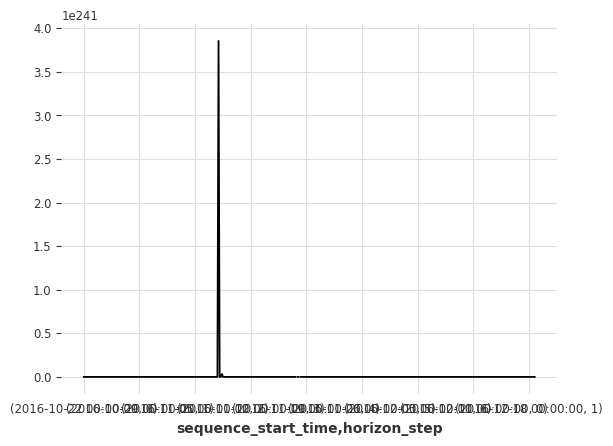

In [108]:
predictions_all['O_Sent (online only) -> O_Refused'].plot()

In [78]:
# First, check the ranges to diagnose the issue
print("Actuals range:", np.min(actuals_values), np.max(actuals_values))
print("Predictions range:", np.min(predictions_values), np.max(predictions_values))

# Calculate metrics with better numeric stability
actuals_values = actuals_all.values.astype(np.float64)  # Use higher precision
predictions_values = predictions_all.values.astype(np.float64)

# Calculate element-wise difference and handle potential issues
diff = predictions_values - actuals_values
abs_diff = np.abs(diff)

# Calculate MAE with safeguards
mae_value = np.mean(abs_diff)
print(f"MAE: {mae_value}")

# Calculate RMSE with safeguards against overflow
# First check if the squared differences are causing overflow
print("Max squared difference:", np.max(np.square(diff)))

# Use a robust calculation approach
squared_diff = np.square(diff)
mean_squared_diff = np.mean(squared_diff)
rmse_value = np.sqrt(mean_squared_diff)
print(f"RMSE: {rmse_value}")

# If still getting overflow, try log-based calculation for large differences
if np.isinf(rmse_value):
    # Get rid of NaN and Inf values
    mask = ~(np.isnan(diff) | np.isinf(diff))
    clean_diff = diff[mask]
    rmse_value = np.sqrt(np.mean(np.square(clean_diff)))
    print(f"RMSE (cleaned): {rmse_value}")

Actuals range: 0.0 471.99999999999983
Predictions range: -7.123077150339441e-08 inf
MAE: inf
Max squared difference: inf
RMSE: inf
RMSE (cleaned): inf


/var/folders/mt/5h6lnpgn3j91r3p_y4f2n8hm0000gn/T/ipykernel_4758/2999895961.py:19: RuntimeWarning: overflow encountered in square
  print("Max squared difference:", np.max(np.square(diff)))
/var/folders/mt/5h6lnpgn3j91r3p_y4f2n8hm0000gn/T/ipykernel_4758/2999895961.py:22: RuntimeWarning: overflow encountered in square
  squared_diff = np.square(diff)
/var/folders/mt/5h6lnpgn3j91r3p_y4f2n8hm0000gn/T/ipykernel_4758/2999895961.py:32: RuntimeWarning: overflow encountered in square
  rmse_value = np.sqrt(np.mean(np.square(clean_diff)))


In [68]:
# For pandas dataframes
def calculate_metrics(actuals_df, predictions_df):
    # Make sure indices are aligned
    common_idx = actuals_df.index.intersection(predictions_df.index)

    # Filter both dataframes to common indices
    actuals = actuals_df.loc[common_idx]
    predictions = predictions_df.loc[common_idx]

    # Calculate metrics column-wise
    results = {}
    for col in actuals.columns:
        if col in predictions.columns:
            mae_val = ((predictions[col] - actuals[col]).abs()).mean()
            rmse_val = ((predictions[col] - actuals[col])**2).mean()**0.5
            results[col] = {'MAE': mae_val, 'RMSE': rmse_val}

    # Calculate overall metrics
    overall_mae = ((predictions - actuals).abs()).values.mean()
    overall_rmse = ((predictions - actuals)**2).values.mean()**0.5

    return results, overall_mae, overall_rmse

# Usage


In [71]:
column_metrics, overall_mae, overall_rmse = calculate_metrics(actuals_all, predictions_all)
print(f"Overall MAE: {overall_mae}")
print(f"Overall RMSE: {overall_rmse}")

ValueError: cannot join with no overlapping index names

In [15]:
def check_bpi2017_dataset():
    # Load config
    with open(Path("../config/base_config.yaml"), "r") as f:
        config = yaml.safe_load(f)

    # Initialize DataLoader
    data_loader = DataLoader(config)

    # Load and prepare BPI2017 data
    dataset = "BPI2017"
    model_group = "statistical"  # Using statistical model group

    try:
        # Load and prepare data
        train, val, test, transformer, _ = data_loader.prepare_data(dataset, model_group)
        logger.info(f"Data loaded: train shape={train.shape()}, test shape={test.shape()}")

        # Create expanding window dataset
        horizon = 7
        input_seq, output_seq = data_loader.create_expanding_io_data(
            train=train,
            val=val,
            test=test,
            horizon=horizon
        )

        # Check data structure
        logger.info(f"Number of sequences: {len(input_seq)}")
        logger.info(f"Input sequence 0 shape: {input_seq[0].shape()}")
        logger.info(f"Output sequence 0 shape: {output_seq[0].shape()}")

        # Check components
        logger.info(f"Components: {train.components}")
        logger.info(f"Input components: {input_seq[0].components}")
        logger.info(f"Output components: {output_seq[0].components}")

        # Check dates
        logger.info(f"Input sequence 0 date range: {input_seq[0].start_time()} to {input_seq[0].end_time()}")
        logger.info(f"Output sequence 0 date range: {output_seq[0].start_time()} to {output_seq[0].end_time()}")

        # Check values of first component
        component = train.components[0]
        logger.info(f"First component: {component}")
        logger.info(f"Input first values: {input_seq[0][component].first_values()}")
        logger.info(f"Output first values: {output_seq[0][component].first_values()}")

        # Check if output starts right after input
        logger.info(f"Output starts right after input: {output_seq[0].start_time() == input_seq[0].end_time() + input_seq[0].freq}")

        # Check expanding window behavior
        if len(input_seq) > 1:
            logger.info(f"Input sequence 1 length: {len(input_seq[1])}")
            logger.info(f"Input sequence 0 length: {len(input_seq[0])}")
            logger.info(f"Difference: {len(input_seq[1]) - len(input_seq[0])}")

        return input_seq, output_seq

    except Exception as e:
        logger.error(f"Error checking BPI2017 dataset: {str(e)}")
        raise

In [16]:
input_seq, output_seq = check_bpi2017_dataset()

2025-03-12 13:21:51,134 - __main__ - ERROR - Error checking BPI2017 dataset: Error preparing data for BPI2017: Dataset not found at data/processed/time_series_df.h5


Exception: Error preparing data for BPI2017: Dataset not found at data/processed/time_series_df.h5